# Credit Screening


## Background

A Japanese credit company produced a dataset showing whether or not customers were granted credit based on fifteen factors. The variables were obscured to retain customer confidentiality. By applying machine learning to historical data, it is possible to predict whether or not a customer will be granted credit. This can be useful for automating credit approval: if the data provided is indicative of how the company would like to grant approval in the future, an algorithm can be deployed to achieve similar results. This can save the credit company both time and money in the future. 

The classification problem can be solved using machine learning. While there are numerous algorithms for predicting binary outcomes, this notebook will use random forest.


## Random Forest and Decision Trees

Random forest works by collecting "votes" from multiple decision trees built on random sampling of the original dataset.

Single decision trees are built through a partitioning and pruning process. In the partitioning phase, samples are plotted in feature space and divided until each division holds a single class. Each split corresponds to a node in the decision tree. Since the resulting tree can contain divisions that do not accurately represent the structure of the data, the next step is to prune the tree to prevent overfitting. The pruning step optimizes between classification error and the number of nodes to select the smallest tree with an error value within a standard deviation from the minimum error tree. The final result is a tree with nodes that divide samples, and leaves that show resulting class distributions.

Random forests work for such datasets because of their versatility and accuracy. The algorithm is suited for a variety of data types, including categorical, discrete, and continuous data. It is also robust to outliers due to the fact that is searches for underlying data structure as opposed to magnitudes. Resulting predictions tend to have high accuracy because random forest combines the outcomes from multiple learning models. This is not to say that the algorithm does not have its own biases. While it is possible to use random forest for feature ranking, it can lead to issues when dealing with correlated features. In a set of correlated features, the algorithm can choose a single variable and reduce the importance of correlated variables. This makes it important to have an understanding of how the various features relate to one another.


## Citation Information

The dataset was created by Chiharu Sano and submitted to the UCI Machine Learning Repository.

Link to the site: http://archive.ics.uci.edu/ml/datasets/credit+approval

In [1]:
# Import modules
import urllib, os, sys
import numpy as np
import pandas as pd
from StringIO import StringIO
from collections import Counter
from itertools import product
%matplotlib inline
import matplotlib.pyplot as plt

# Add to system paths for remaining modules
sys.path.insert(0, '/Users/leahtsao/virtualenv/personal/lib/python2.7/site-packages')
import h2o
from h2o.estimators import H2ORandomForestEstimator
import seaborn as sns

### Gathering Data

The dataset will be downloaded from the UCI repo. Since the dataset is small (31K), it can be directly loaded into memory.

In [2]:
# Download and format data
urllib.URLopener().retrieve('https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', 'credit_data.data')
data_file = open('credit_data.data', 'r').read()
df_all = pd.read_table(StringIO(data_file), sep=',', header=None)
df_all.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,f,g,00280,824,+


There are 15 attributes and a class column. The columns will be renamed to make it easier to refer to attributes and classes.

In [3]:
# Rename columns
attribute_numls = range(1, 16)
columnsls = ['A' + str(x) for x in attribute_numls] + ['Class']
df_all.columns = columnsls
print('Number of entries: ' + str(df_all.shape[0]))
df_all.head(3)

Number of entries: 690


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,Class
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,f,g,00280,824,+


There are 690 samples in the dataset. 


### Sample Split

If the dataset contains uneven class distributions, the resulting algorithm can be biased towards the more common class. Class counts will be summarized.

In [4]:
# Count instances
df_class_count = df_all[['Class', 'A1']].groupby('Class').count().reset_index().rename(columns={'A1':'Count'})
df_class_count

,Class,Count
0,+,307
1,-,383


There are more denied cases than approved cases, but since the samples are not overly skewed in one direction, and the sample size itself is small, all of the datapoints will be included in subsequent analysis.


### Variable Study

It is important to have an idea of how the variables behave in order to determine which ML algorithm to use, prepare the data for modeling, and get an idea of what biases can influence the final results. 

Based on the frame subset shown above, there is a mix of categorical and continuous variables. Categorical variables include A1, A4, A5, A6, A7, A9, A10, A12, and A13. Continuous variables may include A2, A3, A8, A11, A14, and A15, although A11, A14, and A15 can also be categorical. It is difficult to be sure without further work due to the obscurity of the data.


#### Data Types

The first check will search for data types. There should be a mixture of strings, floats, objects, and possibly integers.

In [5]:
# Check data types
df_all.dtypes

A1        object
A2        object
A3       float64
A4        object
A5        object
A6        object
A7        object
A8       float64
A9        object
A10       object
A11        int64
A12       object
A13       object
A14       object
A15        int64
Class     object
dtype: object

There are objects for columns that should show floats or strings/integers. This may be due to missing values. After missing values are found and accounted for, data types will be checked again.


#### Missing Values

In this dataset, missing values have been padded with question marks. To make is simple to search for missing data, question marks will be converted to nulls.

In [6]:
# Look for missing data
df_all_null = df_all.replace('?', np.nan)
df_null_sum = df_all_null.isnull().sum()
df_null_sum[df_null_sum != 0]

/Library/Python/2.7/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


A1     12
A2     12
A4      6
A5      6
A6      9
A7      9
A14    13
dtype: int64

Seven columns contain missing values, but none of the class labels are missing. Samples with missing variable data can be dropped from the dataset, or missing values can be substituted. While removing entries with missing values leads to a less manipulated dataset, it also decreases the size of the frame. Considering how there are only 690 samples, and the frame is not missing a huge number of entries, it makes sense to substitute missing values. The seven attributes with missing values will be studied to see how missing values should be replaced.

Variables that are potentially categorical will be assessed below by showing frequency counts.

In [7]:
# Function to return sorted list of frequencies
def missing_categorical_counts(data):
    
    # Apply counter and return sorted values
    counted = Counter(data).items()
    sorted_countls = sorted(counted, key = lambda x: x[1])[::-1]
    
    return sorted_countls

null_catls = ['A' + str(x) for x in [1] + range(4, 8) + [14]]
null_cat_outputls = []
for curr_cat in null_catls:
    curr_cat_output = missing_categorical_counts(list(df_all_null[curr_cat]))
    null_cat_outputls.append(curr_cat_output)

# Report frequency counts
df_missing_cat = pd.DataFrame(zip(null_catls, null_cat_outputls), columns=['Factor', 'Counts'])
df_missing_cat

,Factor,Counts
0,A1,"[(b, 468), (a, 210), (nan, 12)]"
1,A4,"[(u, 519), (y, 163), (nan, 6), (l, 2)]"
2,A5,"[(g, 519), (p, 163), (nan, 6), (gg, 2)]"
3,A6,"[(c, 137), (q, 78), (w, 64), (i, 59), (aa, 54)..."
4,A7,"[(v, 399), (h, 138), (bb, 59), (ff, 57), (nan,..."
5,A14,"[(00000, 132), (00120, 35), (00200, 35), (0016..."


A14 does appear to be a categorical attribute. Since the modes for all the examined factors are greater than the second most frequent values, modes will be substituted for missing categorical values.

In [8]:
# Substitute missing categorical values with modes
df_missing_cat.loc[:,'Mode'] = pd.Series(df_missing_cat['Counts'].apply(lambda x: x[0][0]))
cat_fill = zip(df_missing_cat['Factor'], df_missing_cat['Mode'])
for curr_cat_fill in cat_fill:
    df_all_null.loc[:,curr_cat_fill[0] + '_fill'] = pd.Series(df_all_null[curr_cat_fill[0]].fillna(curr_cat_fill[1]))

A2 also has missing values. Since this is a continuous variable, descriptive statistics will be reported below.

In [9]:
# Function to describe variable
def desc_var(data, col_name):
    
    # Descriptive statistics
    r_min = np.nanmin(data)
    r_max = np.nanmax(data)
    r_med = round(np.nanmedian(data), 2)
    r_mean = round(np.nanmean(data), 2)
    r_std = round(np.nanstd(data), 2)
    
    # Create table
    df_desc_stats = pd.DataFrame([r_min, r_max, r_med, r_mean, r_std], columns=[col_name]).rename({0:'Min', 1:'Max', 2:'Med', 3:'Mean', 4:'Std'})
    
    return df_desc_stats

# Convert to float and apply function
df_all_null.loc[:,'A2'] = pd.Series(df_all_null['A2'].astype(float))
df_a2_desc = desc_var(list(df_all_null['A2']), 'A2')
df_a2_desc

,A2
Min,13.75
Max,80.25
Med,28.46
Mean,31.57
Std,11.95


The mean is higher than the median, which suggests that there are large values skewing the curve. A histogram will be plotted below.

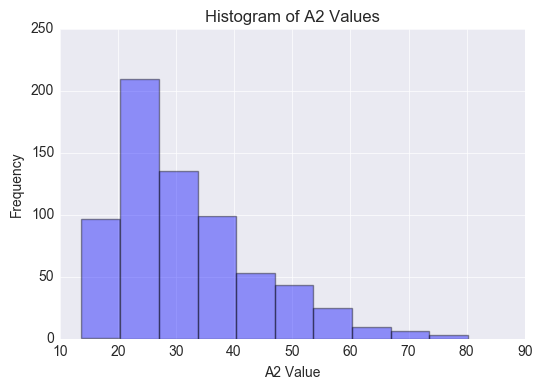

In [10]:
# Drop null values and plot
sns.set_style('darkgrid')
a2_rm_null = df_all_null[['A2']].dropna().reset_index(drop=True)
plot = plt.figure()
ax1 = plot.add_subplot(111)
ax1.hist(list(a2_rm_null['A2']), alpha=0.4)
ax1.set_xlabel('A2 Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of A2 Values')
plt.show()
plt.close()

The mean should be used to substitute missing A2 values to take the positive skew into account.

In [11]:
# Fill missing A2 values with mean
df_all_null.loc[:,'A2_fill'] = pd.Series(df_all_null['A2'].fillna(df_a2_desc.get_value(index='Mean', col='A2')))

Filled values will be checked below to make sure missing values were correctly substituted.

In [12]:
# Check substituted values
original_missls = null_catls + ['A2']
sub_missls = [x + '_fill' for x in original_missls]
check_missls = zip(original_missls, sub_missls)
print('Substituted values')
for curr_col in check_missls:
    # Get index list of missing values
    df_sub = df_all_null[[curr_col[0]]]
    df_miss = df_sub[df_sub[curr_col[0]].isnull() == True]
    # Show unique values in substituted list
    df_fill = df_all_null[[curr_col[1]]]
    df_fill_check = df_fill[df_fill.index.isin(list(df_miss.index))]
    print(curr_col[0] + ': ' + str(list(set(list(df_fill_check[curr_col[1]])))))

Substituted values
A1: ['b']
A4: ['u']
A5: ['g']
A6: ['c']
A7: ['v']
A14: ['00000']
A2: [31.57]


The correct values were substituted. A new frame with final column names and data types will be shown below.

In [13]:
# Create formatted frame
flip_missls = []
for curr_entry in check_missls:
    flip_missls.append((curr_entry[1], curr_entry[0]))
df_formatted = df_all_null.drop(original_missls, 1).rename(columns=dict(flip_missls))

# Check for missing alues
print('Missing values: ' + str(df_formatted.isnull().values.any()))

# Check data types
df_formatted.dtypes

Missing values: False


A3       float64
A8       float64
A9        object
A10       object
A11        int64
A12       object
A13       object
A15        int64
Class     object
A1        object
A4        object
A5        object
A6        object
A7        object
A14       object
A2       float64
dtype: object

There are no more missing values. The cell below will be used to change the data type for the non-string variable.

In [14]:
# Format data type
df_formatted.loc[:,'A14'] = pd.Series(df_formatted['A14'].apply(lambda x: int(x)))
df_formatted.dtypes

A3       float64
A8       float64
A9        object
A10       object
A11        int64
A12       object
A13       object
A15        int64
Class     object
A1        object
A4        object
A5        object
A6        object
A7        object
A14        int64
A2       float64
dtype: object

The frame is now ready for correlation studies. 


#### Correlation Study

Scatter matrices will be generated for both classes to get a sense of how the data is distributed. This is important because highly correlated classes can be substituted when conducting feature importance evaluations. Dummy variables will be assigned for string data types. These dummy variables are for examining correlations, not for downstream ML.

In [14]:
# Assign dummy variables
columnls = list(df_formatted.columns)
dummy_varls = []
for curr_var in columnls:
    if (type(df_formatted[curr_var].loc[0]) == str) & (curr_var != 'Class'):
        dummy_varls.append(curr_var)
        curr_setls = df_formatted[curr_var].unique()
        curr_map = pd.Series(range(0, len(curr_setls)), index=curr_setls)
        df_formatted.loc[:,curr_var + '_dummy'] = df_formatted[curr_var].map(curr_map)
    else:
        continue
print('Added dummy variables: ' + str(dummy_varls))

Added dummy variables: ['A9', 'A10', 'A12', 'A13', 'A1', 'A4', 'A5', 'A6', 'A7']


Attributes with dummy variables will be removed from the frame, and the original dataset will be split into positive and negative classes for correlation matrices. Strings will be used instead of integers for downstream ML work.

In [15]:
# Remove original attributes if dummy variables are present
df_formatted.loc[:,'Class'] = pd.Series(df_formatted['Class'].replace({'+':'a', '-':'b'}))
df_corr = df_formatted.drop(dummy_varls, 1)
df_0 = df_corr[df_corr['Class'] == 'b'].reset_index(drop=True)
df_1 = df_corr[df_corr['Class'] == 'a'].reset_index(drop=True)
print('Number of negative entries: ' + str(df_0.shape[0]))
print('Number of positive entries: ' + str(df_1.shape[0]))

Number of negative entries: 383
Number of positive entries: 307


There are more negative than positive entries. The matrix for rejected entries will be shown below.

Scatter Matrix (Negative)


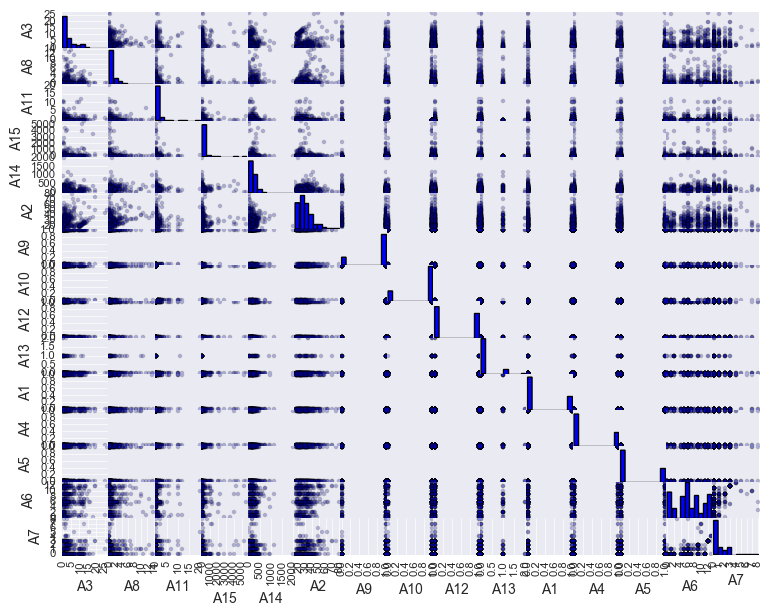

In [16]:
# Dictionary to rename dummy variables
dummy_var_rmls = [x + '_dummy' for x in dummy_varls]
rename_dummy_dict = dict(zip(dummy_var_rmls, dummy_varls))

# Matrix for negative samples
print('Scatter Matrix (Negative)')
pd.tools.plotting.scatter_matrix(df_0.drop(['Class'], 1).rename(columns=rename_dummy_dict), figsize=(9, 7), alpha=0.2)
plt.show()
plt.close()

There don't appear to be any strong correlations for the negative samples.

Scatter Matrix (Positive)


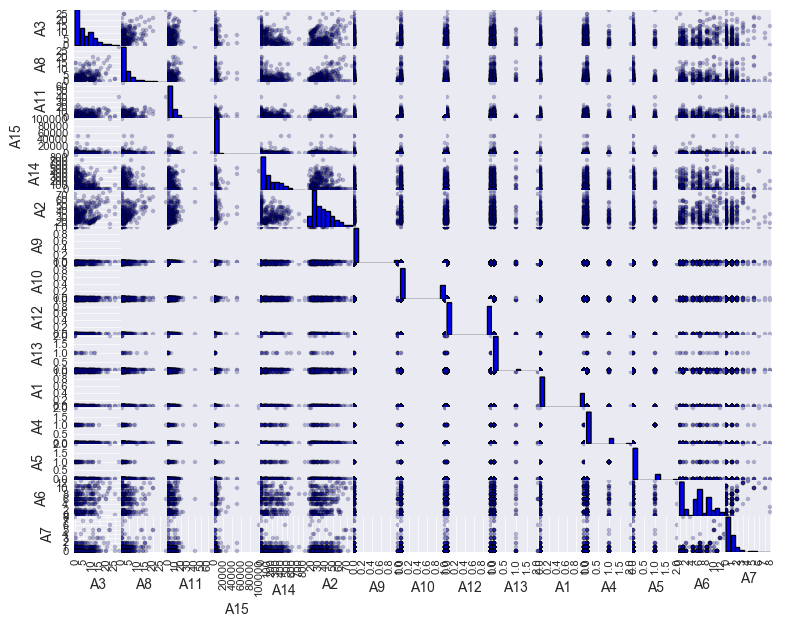

In [17]:
# Matrix for positive samples
print('Scatter Matrix (Positive)')
pd.tools.plotting.scatter_matrix(df_1.drop(['Class'], 1).rename(columns=rename_dummy_dict), figsize=(9, 7), alpha=0.2)
plt.show()
plt.close()

There also aren't any strong correlations for the positive samples. It will be easier to interpret feature importance rankings because one feature will not be selected and decrease the importance of its correlating features.


### Random Forest

Random forest will be used to predict whether or not applicants are accepted for reasons stated in the introduction. H2O will be used to accomplish this task because the random forest estimator accepts categorical features without the need for one-hot encoding, which can decrease accuracy due to the increased dimensionality. A pandas frame will be formatted for H2O by removing the dummy variables.

In [18]:
# Format pandas frame and read into h2o
df_rf = df_formatted.drop(dummy_var_rmls, 1)
h2o.init()
df_h2o = h2o.H2OFrame(df_rf)
print('Number of entries: ' + str(df_h2o.shape[0]))
df_h2o.tail(3)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_60"; Java(TM) SE Runtime Environment (build 1.8.0_60-b27); Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from /Users/leahtsao/virtualenv/personal/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m0/qwg0j0n92y1826spx_91gnb00000gp/T/tmpL3pBM3
  JVM stdout: /var/folders/m0/qwg0j0n92y1826spx_91gnb00000gp/T/tmpL3pBM3/h2o_leahtsao_started_from_python.out
  JVM stderr: /var/folders/m0/qwg0j0n92y1826spx_91gnb00000gp/T/tmpL3pBM3/h2o_leahtsao_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster version:,3.14.0.3
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_leahtsao_7sg4v0
H2O cluster total nodes:,1
H2O cluster free memory:,910 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
Number of entries: 690


A3,A8,A9,A10,A11,A12,A13,A15,Class,A1,A4,A5,A6,A7,A14,A2
13.5,2,f,t,1,t,g,1,b,a,y,p,ff,ff,200,25.25
0.205,0.04,f,f,0,f,g,750,b,b,u,g,aa,v,280,17.92
3.375,8.29,f,f,0,t,g,0,b,b,u,g,c,h,0,35


Since the dataset is small, the frame will be split into training and testing sets for cross validation.

In [19]:
df_train, df_test = df_h2o.split_frame(ratios=[0.6], seed=0)
print('Number of training entries: ' + str(df_train.shape[0]))
print('Number of testing entries: ' + str(df_test.shape[0]))

Number of training entries: 429
Number of testing entries: 261


Training attributes and the target column will be specified below.

In [20]:
# Specify training and targets
training_columns = ['A' + str(x) for x in range(1, 16)]
target_column = 'Class'

The first iteration of random forest will use the default settings. 

In [21]:
model_v1 = H2ORandomForestEstimator(model_id='rf_v1', seed=1, score_each_iteration=False)
model_v1.train(x=training_columns, y=target_column, training_frame=df_train)
model_v1.auc()

drf Model Build progress: |███████████████████████████████████████████████| 100%


0.9148735581188998

The area under the ROC curve (AUC) can be used to assess model performance. A model without errors will have a score of 1.0, while a test that results in random guesses will have a score of 0.5. The area under the ROC curve is currently 0.91, which is good for a first iteration. 

There are several parameters that can be adjusted to increase performance for random forests. The variables that are likely to lead to the greatest increase in accuracy are the number of trees created (ntree), the number of variables available to each tree (mtries), and tree depth (max_depth). Before these factors can be adjusted, a function for finding model parameters will be written below.

In [22]:
# Function to return input parameters
def find_params(model):
    
    # Get params
    curr_params = model.params
    ntree = curr_params['ntrees']['actual']
    mtries = curr_params['mtries']['actual']
    max_depth = curr_params['max_depth']['actual']
    
    return [ntree, mtries, max_depth]

This function will be applied to model 1.

In [23]:
# Find model parameters for v1
find_params(model_v1)

[50, -1, 20]

The first version had 50 trees, 3 parameters available for each tree (the default is the square root of the number of variables rounded down), and a max depth of 20. For variable tuning, the number of trees will vary from 50 to 100 in increments of 10, the number of parameters will range from 3 to 5, and the max depth will vary from 10 to 30 in increments of 5. A list of these conditions will be made below.

In [24]:
# Create testing conditions
ntree_inputls = range(50, 110, 10)
mtries_inputls = range(3, 6, 1)
max_depth_inputls = range(10, 35, 5)
parameter_testls = list(product(ntree_inputls, mtries_inputls, max_depth_inputls))
print('Number of testing conditions: ' + str(len(parameter_testls)))

Number of testing conditions: 90


The function below will be used to run models. Since there is randomness associated with each combination, each combination will run five times. The mean AUC along with the standard deviation will be reported.

In [25]:
# Function to test input parameters
def random_forest_specify_parameters(parameters, training_columns, target_column, df_train):
    
    # Iteration and AUC list
    aucls = []
    run_countls = range(0, 5)
    
    # Run model
    for curr_run in run_countls:
        h2o.no_progress()
        model = H2ORandomForestEstimator(ntrees = parameters[0], mtries = parameters[1], max_depth = parameters[2], score_each_iteration=False)
        model.train(x=training_columns, y=target_column, training_frame=df_train)
        aucls.append(model.auc())
    
    # Calculate mean and SD for AUCs
    auc_mean = np.mean(aucls)
    auc_std = np.std(aucls)
    
    return auc_mean, auc_std

Summary values will be calculated below. The five conditions that result in the highest mean AUC values will be reported below.

In [26]:
# Run through testing conditions
auc_outputls = []
for curr_parameters in parameter_testls:
    curr_auc = random_forest_specify_parameters(curr_parameters, training_columns, target_column, df_train)
    auc_outputls.append(curr_auc)

# Show summary table
df_iter = pd.DataFrame(zip(parameter_testls, auc_outputls), columns=['Parameters', 'AUC_Results'])
df_iter[['ntree', 'mtries', 'max_depth']] = df_iter['Parameters'].apply(pd.Series)
df_iter[['AUC_mean', 'AUC_std']] = df_iter['AUC_Results'].apply(pd.Series)
df_report = df_iter.drop(['Parameters', 'AUC_Results'], 1).reindex_axis(['ntree', 'mtries', 'max_depth', 'AUC_mean', 'AUC_std'], 1)
print('Top 5 AUC values:')
df_report.sort_values(['AUC_mean'], ascending=False).reset_index(drop=True).head(5)

Top 5 AUC values:


,ntree,mtries,max_depth,AUC_mean,AUC_std
0,100,3,30,0.926912,0.003919
1,100,4,10,0.925113,0.002008
2,70,3,10,0.924496,0.001116
3,80,4,25,0.924217,0.006492
4,90,5,30,0.924204,0.003627


Interestingly enough, the top AUC mean values are not far removed from the score that resulted using default settings. This is one benefit of using random forest: high model accuracies can be acquired with little refinement. 

The main factor that led to the increased score was increasing the number of decision trees. Altering the number of randomly selected variables did not significantly increase the score. This may be because few factors predominantly explain whether or not an applicant is accepted or rejected. Changing the max depth also did not heavily alter results. In fact, it may have led to more noise capture. 

The conditions that led to the third highest score will be used for the final model because the score averages are similar, but the standard deviation is small. This model will be recreated and applied to the test set.

In [27]:
# Run model and apply to test set
model_v2 = H2ORandomForestEstimator(model_id='rf_v2', seed=2, score_each_iteration=False, ntrees=70, mtries=3, max_depth=10)
model_v2.train(x=training_columns, y=target_column, training_frame=df_train)
model_v2_performance = model_v2.model_performance(test_data=df_test)
print('Test AUC: ' + str(model_v2_performance.auc()))

Test AUC: 0.941704960528


The AUC from the test data is high, yet similar to the results from the test data. This suggests that the model did not overfit. The final ROC will be shown below.

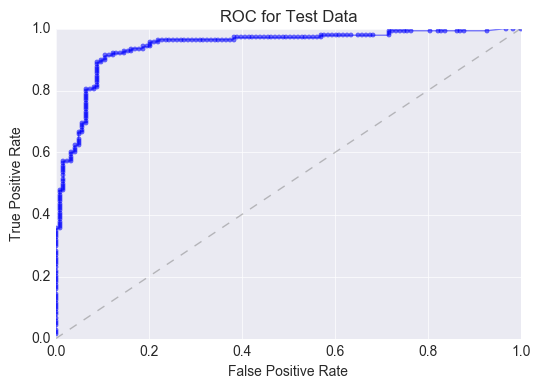

In [28]:
# Plot ROC
fprs = model_v2_performance.fprs
tprs = model_v2_performance.tprs
df_roc = pd.DataFrame(zip(fprs, tprs), columns=['False Positive Rate', 'True Positive Rate'])
plot = plt.figure()
ax1 = plot.add_subplot(111)
ax1.plot(df_roc['False Positive Rate'], df_roc['True Positive Rate'], alpha=0.5, marker='.')
ax1.plot([0.0, 1.0], [0.0, 1.0], alpha=0.5, linestyle='--', color='gray')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC for Test Data')
plt.show()
plt.close()

The ROC is far from the 50-50 line and hugs the upper left corner. These characteristics show that the algorithm is not merely guessing the resulting class. The confusion matrix will be analyzed next.

In [29]:
# Show confusion matrix generated from test data
model_v2_performance.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.641904761536: 


,a,b,Error,Rate
a,110.0,13.0,0.1057,(13.0/123.0)
b,12.0,126.0,0.087,(12.0/138.0)
Total,122.0,139.0,0.0958,(25.0/261.0)


The confusion matrix shows actual classifications in the row indices and predicted classifications in the column names. The values are determined when the precision and recall scores are close. Evaluation score summaries are shown below.

In [30]:
# Calculate evaluation values
tp = 110.0
tn = 126.0
fp = 12.0
fn = 13.0
print('Accuracy: ' + str(round((tp + tn) / (tp + tn + fp + fn), 4) * 100) + '%')
print('Sensitivity/Recall: ' + str(round(tp / (tp + fn), 4) * 100) + '%')
print('Specificity: ' + str(round(tn / (tn + fp), 4) * 100) + '%')
print('Precision: ' + str(round(tp / (tp + fp), 4) * 100) + '%')

Accuracy: 90.42%
Sensitivity/Recall: 89.43%
Specificity: 91.3%
Precision: 90.16%


According to the scores above, the model has high overall accuracy, but it is better at separating actual negative samples than it is at separating actual positive samples. The vast majority of positive predictions were also correct. Variable importances will be sorted next.

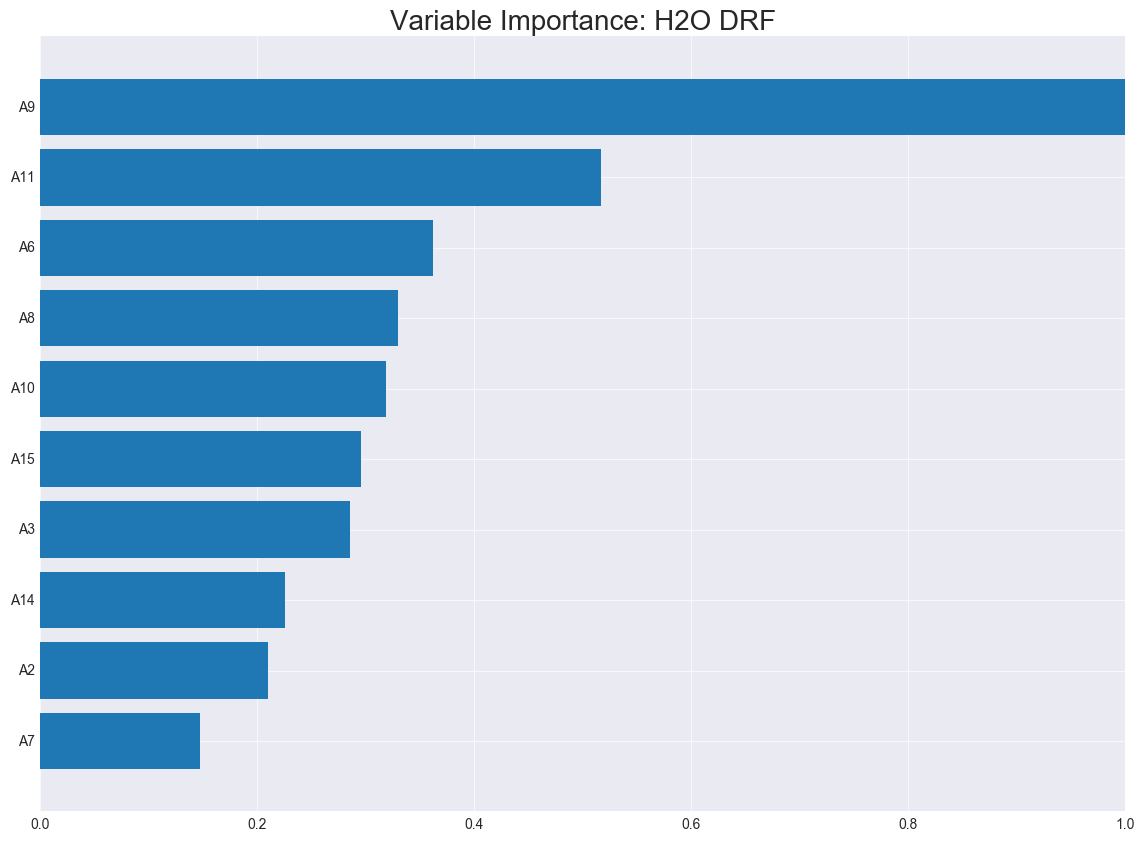

In [31]:
model_v2.varimp_plot()

The feature with the most predicting power is A9. This can explain why increasing the number of variables available to each decision tree did not dramatically improve performance. Feature A11 also significantly contributes to performance. 

Now that the model has been trained, tuned, and tested, H2O can be closed.

In [32]:
h2o.shutdown()

[WARNING] in <ipython-input-32-bd1e984f485f> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_bff6 closed.


# Conclusion

A tuned random forest model was made to predict whether or not customer credit requests would be approved or denied based on historical data. The dataset itself contained 15 obscured variables and 690 samples. Out of the 15 variables, two were determined to have the most impact on approval outcomes. When the final model was used to make predictions on the test data, the AUC was 94.17%, and the model was found to be slightly stronger at identifying actual negative samples compared to actual positive samples. 

The score is most likely to be improved by increasing the size of the dataset. Large training sets make it easier for algorithms to recognize underlying patterns, and large testing sets produce evaluation scores that are more indicative of how the model is actually performing.